In [1]:
# necessary packages
import pandas as pd
import multiprocessing as mp
import time
import pickle
import networkx
import matplotlib.pyplot as plt

## Creating a DataFrame from the Dataset

In [3]:
def load_data(filename):
    df = pd.read_csv(filename)
    return df
df = load_data('data.csv')

## Creating Address Clusters

In [7]:
def get_input_addrs(tx):
    return set(df[df['tx_hash'] == tx]['inputs_addresses'])

def get_prelim_clusters(df):
    start = time.time()
    with mp.Pool() as pool:
        prelim = pool.map(get_input_addrs, set(df['tx_hash']))
        pool.close()
        pool.join()
    end = time.time()
    print(f'Creating the prelim clusters took {round((end - start) / 60, 2)} min.')
    return prelim

def construct_clusters(prelim):
    def pairs(lst):
        i = iter(lst)
        first = prev = item = next(i)
        for item in i:
            yield prev, item
            prev = item
        yield item, first
        
    graph = networkx.Graph()
    for cluster in prelim:
        for edge in pairs(cluster):
            graph.add_edge(*edge)
    clusters = list(networkx.connected_components(graph))
    return clusters

def write_clusters(clusters):
    clusters.sort(key=len, reverse=True)
    lookup = {'addrs': [], 'cluster_num': [], 'label': [], 'entity': []}
    for idx, cluster in enumerate(clusters):
        for addr in cluster:
            lookup['addrs'].append(addr)
            lookup['cluster_num'].append(idx + 1)
            lookup['label'].append(None)
            lookup['entity'].append(None)
    pd.DataFrame.from_dict(lookup).to_csv('clusters.csv', index=False)

# prelim = get_prelim_clusters(df)
# clusters = construct_clusters(prelim)
# write_clusters(clusters)

## Labeling the Data

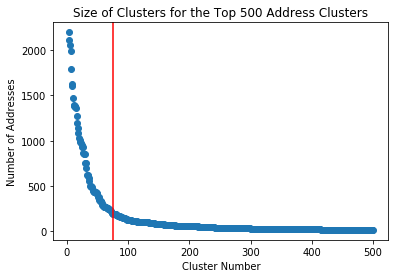

The top 75 clusters (in terms of size) contain 29.62% of the addresses.


In [25]:
clusters = pd.read_csv('clusters.csv')
gb = clusters.groupby('cluster_num', as_index = False).count()
# plt.bar(gb['addrs'][:1000])
plt.scatter(gb['cluster_num'][2:500], gb['addrs'][2:500])
plt.axvline(75, color = 'red')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Addresses')
plt.title('Size of Clusters for the Top 500 Address Clusters')
plt.show()
percent = round(sum(gb['addrs'][:75])/sum(gb['addrs']) * 100, 2)
print(f'The top 75 clusters (in terms of size) contain {percent}% of the addresses.')